In [110]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_ollama import ChatOllama


In [111]:
llm = ChatOllama(model="llama3.1:latest", temperature=0)


In [112]:
from typing_extensions import TypedDict

class OverallState(TypedDict):
    query:str
    industry:str
    role:str
    channels:str

In [113]:
from pydantic import BaseModel, Field
from typing import List, Literal

class survey_type(BaseModel):
    industry: Literal["saas", "eCommerce", "other"] = Field(..., description="The industry the survey is for.")
    role: Literal["productManager", "marketing", "sales", "customerSuccess", "peopleManager"] = Field(..., description="The role of the person responsible for creating the survey.")
    channels: List[Literal["app", "website", "link"]] = Field(..., description="Where the survey will be distributed (can be multiple channels).")

find_survey_type_prompt = """
Analyze the given topic and determine the most relevant survey parameters.
Topic: {topic}

Return a JSON object with:
- "industry": Choose from ["saas", "eCommerce", "other"]
- "role": Choose from ["productManager", "marketing", "sales", "customerSuccess", "peopleManager"]
- "channels": A list of ["app", "website", "link"]
"""


def find_survey_type(state:OverallState):
    """find the survey type"""
    prompt  = find_survey_type_prompt.format(topic=state["query"])
    response = llm.with_structured_output(survey_type).invoke(prompt)

    return {"industry":response.industry,"role":response.role,"channels":response.channels, }


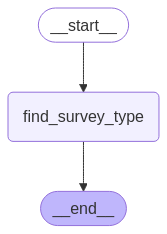

In [114]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph =  StateGraph(OverallState)


graph.add_node("find_survey_type", find_survey_type)

graph.add_edge(START, "find_survey_type")
graph.add_edge("find_survey_type", END)

graph = graph.compile()


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [115]:
result  = graph.invoke({"query":"I want a survey to measure trial-to-paid conversion rates."})
result

{'query': 'I want a survey to measure trial-to-paid conversion rates.',
 'industry': 'saas',
 'role': 'customerSuccess',
 'channels': ['app', 'website']}